# PAGA

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import os

In [2]:
# rpy2 
os.environ['R_HOME'] = '/home/fdeckert/bin/miniconda3/envs/p.3.8.12-FD20200109SPLENO/lib/R'

In [3]:
# Scanpy settings  
sc.settings.verbosity=0
sc.settings.vector_friendly = False
sc.set_figure_params(figsize=(3, 4), dpi_save=1200, fontsize=10, frameon=False)
sc.settings.figdir = "result/figures/"

In [4]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

In [5]:
# Plotting 
import rpy2.robjects as robjects
color_load = robjects.r.source('plotting_global.R')
color = dict()
for i in range(len(color_load[0])):
    color[color_load[0].names[i]] = {key : color_load[0][i].rx2(key)[0] for key in color_load[0][i].names}

# Import data

In [6]:
adata = sc.read_h5ad('data/object/pp.h5ad')
adata.X = adata.X.astype('int')
adata.raw = adata

In [7]:
obs = pd.read_csv('data/object/components/meta.csv', index_col=0)
obs = obs.reindex(adata.obs_names)
adata.obs = obs

# Set colors 

In [8]:
def set_color(categories): 
    
    categories = [x for x in categories if x in list(adata.obs.columns)]

    for category in categories: 

        adata.obs[category] = pd.Series(adata.obs[category], dtype='category')
        
        keys = list(color[category].keys())
        keys = [x for x in keys if x in list(adata.obs[category])]

        adata.obs[category] = adata.obs[category].cat.reorder_categories(keys)
        adata.uns[category+'_colors'] = np.array([color[category].get(key) for key in keys], dtype=object)
        
# Set colors
set_color(list(color.keys()))

# Store full adata

In [9]:
adata_tmp = adata.copy()

# PAGA

In [10]:
# Normalize and scale 
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

# Dim reduction, SNN, and leiden 
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

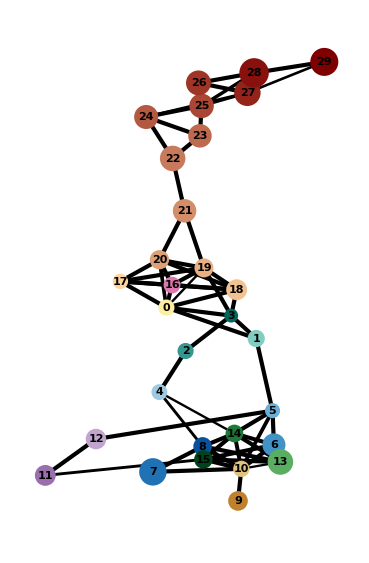

<Axes:>

In [11]:
sc.tl.paga(adata, groups='cell_type_fine')
sc.pl.paga(adata, color='cell_type_fine', node_size_scale=0.5, threshold=0, fontoutline=0, fontsize=0, frameon=False, layout='fa', edge_width_scale=0.25, save=".png", show=False)

adata.obs['paga_label'] = adata.obs['cell_type_fine']
adata.obs['paga_label'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']

sc.pl.paga(adata, color='cell_type_fine', title="", labels=adata.obs['paga_label'].cat.categories, node_size_scale=0.5, threshold=0.5, fontsize=5, frameon=False, layout='fa', edge_width_scale=0.25, save=".png", pos=adata.uns['paga']['pos'])
sc.pl.paga(adata, color='cell_type_fine', title="", labels=adata.obs['paga_label'].cat.categories, node_size_scale=0.5, threshold=0.5, fontsize=5, frameon=False, layout='fa', edge_width_scale=0.25, save=".pdf", show=False)

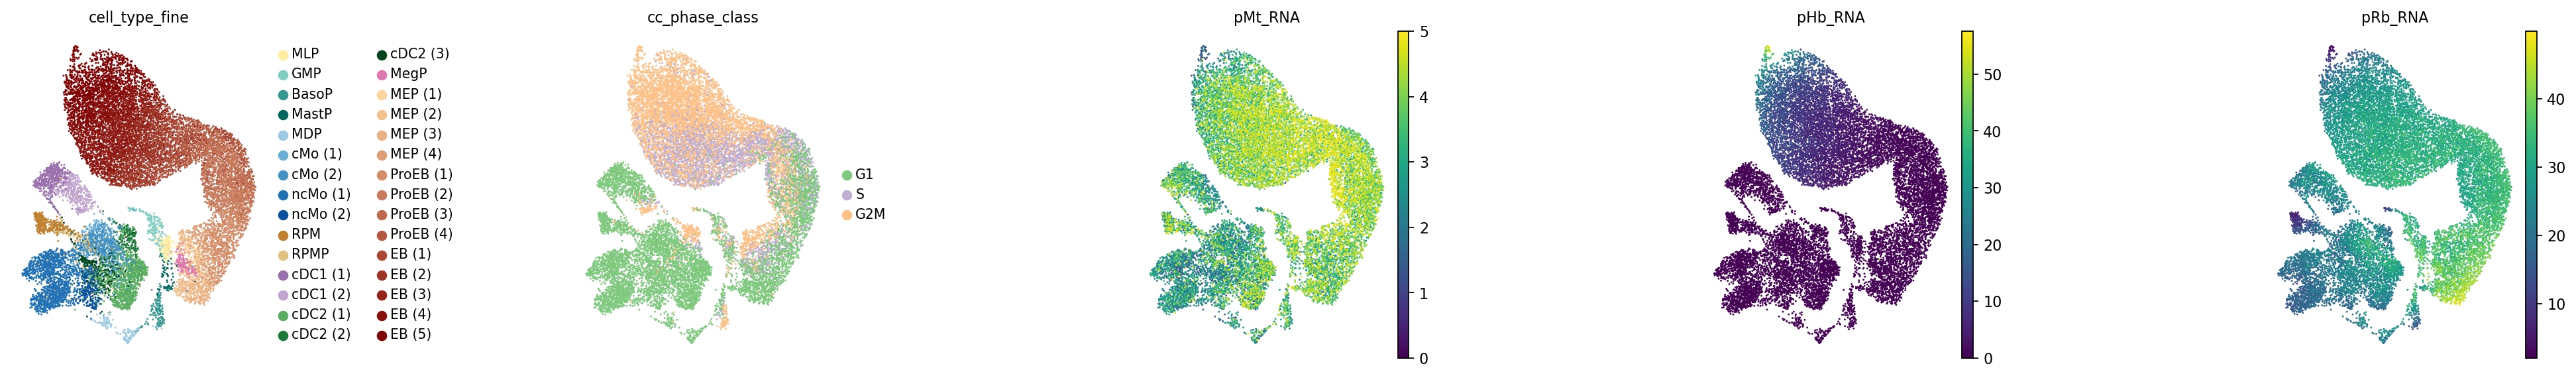

In [12]:
# UMAP
sc.tl.umap(adata, init_pos='paga', min_dist=1.5, spread=2)
sc.pl.umap(adata, color=['cell_type_fine', 'cc_phase_class', 'pMt_RNA', 'pHb_RNA', 'pRb_RNA'], wspace=1, ncols=5)

In [13]:
# Store h5ad
adata.write_h5ad('data/object/paga/adata.h5ad')

# Save PAGA results 
connectivities = adata.uns['paga']['connectivities'].todense()
groups = adata.obs['cell_type_fine'].cat.categories
pd.DataFrame(connectivities, columns=groups, index=groups).to_csv('result/paga/connectivities.csv', index_label=0)

# Save UMAP results 
pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names.to_series()).to_csv('data/object/components/umap_paga.csv')

# PAGA (NaCl)

In [14]:
adata_nacl = adata_tmp[adata_tmp.obs['treatment']=='NaCl'].copy()

# Normalize and scale 
sc.pp.normalize_total(adata_nacl)
sc.pp.log1p(adata_nacl)
sc.pp.scale(adata_nacl)

# Dim reduction, SNN, and leiden 
sc.tl.pca(adata_nacl, n_comps=50)
sc.pp.neighbors(adata_nacl, n_neighbors=30, n_pcs=50)

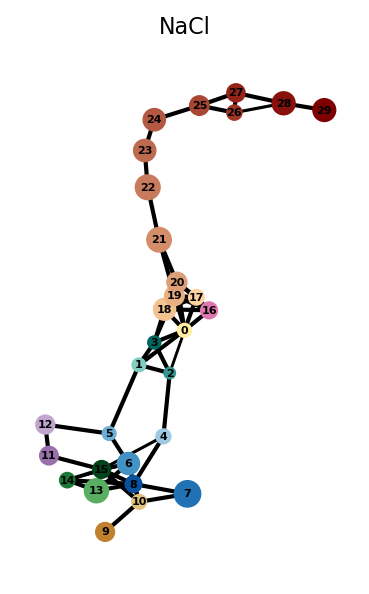

<Axes:title={'center':'NaCl'}>

In [15]:
sc.tl.paga(adata_nacl, groups='cell_type_fine')
sc.pl.paga(adata_nacl, color='cell_type_fine', node_size_scale=0.5, threshold=0, fontoutline=0, fontsize=0, frameon=False, layout='fa', edge_width_scale=0.25, save="_nacl.png", show=False)

adata_nacl.obs['paga_label'] = adata_nacl.obs['cell_type_fine']
adata_nacl.obs['paga_label'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']

sc.pl.paga(adata_nacl, color='cell_type_fine', title="NaCl", labels=adata_nacl.obs['paga_label'].cat.categories, node_size_scale=0.5, threshold=0.5, fontsize=5, frameon=False, layout='fa', edge_width_scale=0.25, save="_nacl.png", pos=adata_nacl.uns['paga']['pos'])
sc.pl.paga(adata_nacl, color='cell_type_fine', title="NaCl", labels=adata_nacl.obs['paga_label'].cat.categories, node_size_scale=0.5, threshold=0.5, fontsize=5, frameon=False, layout='fa', edge_width_scale=0.25, save="_nacl.pdf", show=False)

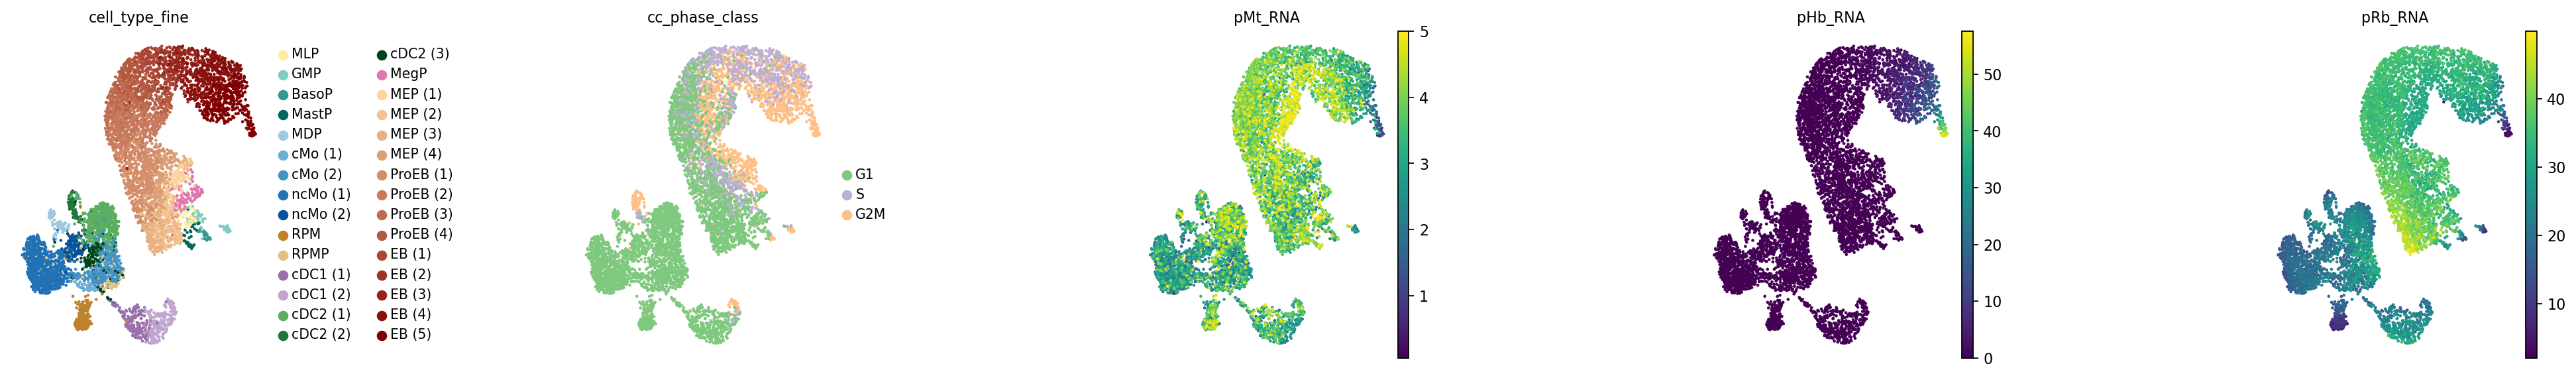

In [16]:
# UMAP
sc.tl.umap(adata_nacl, init_pos='paga', min_dist=1.5, spread=2)
sc.pl.umap(adata_nacl, color=['cell_type_fine', 'cc_phase_class', 'pMt_RNA', 'pHb_RNA', 'pRb_RNA'], wspace=1, ncols=5)

In [17]:
# Store h5ad
adata_nacl.write_h5ad('data/object/paga/adata_nacl.h5ad')

# Save PAGA results 
connectivities = adata_nacl.uns['paga']['connectivities'].todense()
groups = adata_nacl.obs['cell_type_fine'].cat.categories
pd.DataFrame(connectivities, columns=groups, index=groups).to_csv('result/paga/connectivities_nacl.csv', index_label=0)

# Save UMAP results 
pd.DataFrame(adata_nacl.obsm['X_umap'], index=adata_nacl.obs_names.to_series()).to_csv('data/object/components/umap_paga_nacl.csv')

# PAGA (CpG)

In [18]:
adata_cpg = adata_tmp[adata_tmp.obs['treatment']=='CpG'].copy()

# Normalize and scale 
sc.pp.normalize_total(adata_cpg)
sc.pp.log1p(adata_cpg)
sc.pp.scale(adata_cpg)

# Dim reduction, SNN, and leiden 
sc.tl.pca(adata_cpg, n_comps=50)
sc.pp.neighbors(adata_cpg, n_neighbors=30, n_pcs=50)

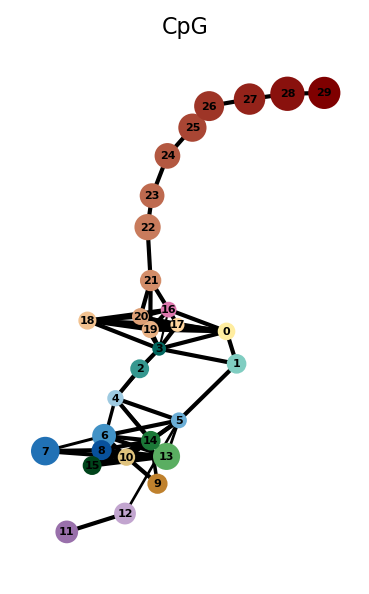

<Axes:title={'center':'CpG'}>

In [19]:
sc.tl.paga(adata_cpg, groups='cell_type_fine')
sc.pl.paga(adata_cpg, color='cell_type_fine', node_size_scale=0.5, threshold=0, fontoutline=0, fontsize=0, frameon=False, layout='fa', edge_width_scale=0.25, save="_cpg.png", show=False)

adata_cpg.obs['paga_label'] = adata_cpg.obs['cell_type_fine']
adata_cpg.obs['paga_label'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']

sc.pl.paga(adata_cpg, color='cell_type_fine', title="CpG", labels=adata_cpg.obs['paga_label'].cat.categories, node_size_scale=0.5, threshold=0.5, fontsize=5, frameon=False, layout='fa', edge_width_scale=0.25, save="_cpg.png", pos=adata_cpg.uns['paga']['pos'])
sc.pl.paga(adata_cpg, color='cell_type_fine', title="CpG", labels=adata_cpg.obs['paga_label'].cat.categories, node_size_scale=0.5, threshold=0.5, fontsize=5, frameon=False, layout='fa', edge_width_scale=0.25, save="_cpg.pdf", show=False)

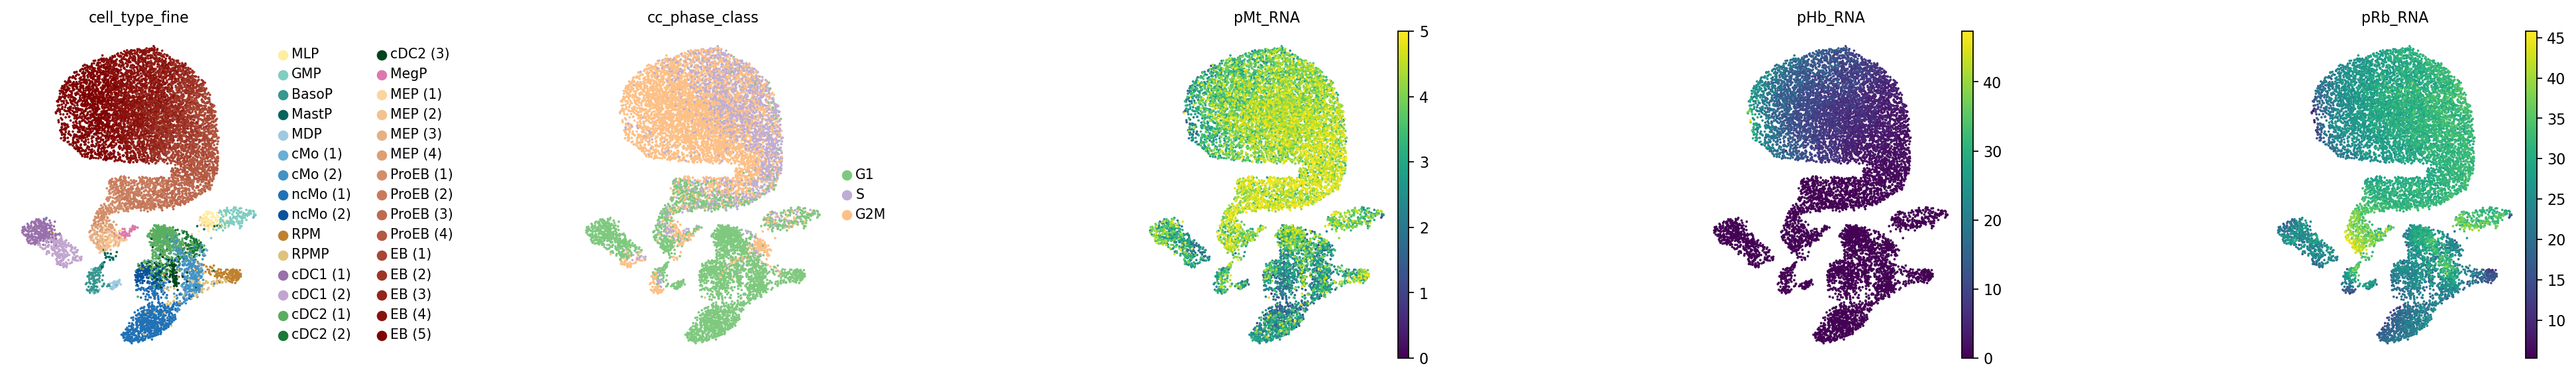

In [20]:
# UMAP
sc.tl.umap(adata_cpg, init_pos='paga', min_dist=1.5, spread=2)
sc.pl.umap(adata_cpg, color=['cell_type_fine', 'cc_phase_class', 'pMt_RNA', 'pHb_RNA', 'pRb_RNA'], wspace=1, ncols=5)

In [21]:
# Store h5ad
adata_cpg.write_h5ad('data/object/paga/adata_cpg.h5ad')

# Save PAGA results 
connectivities = adata_cpg.uns['paga']['connectivities'].todense()
groups = adata_cpg.obs['cell_type_fine'].cat.categories
pd.DataFrame(connectivities, columns=groups, index=groups).to_csv('result/paga/connectivities_cpg.csv', index_label=0)

# Save UMAP results 
pd.DataFrame(adata_cpg.obsm['X_umap'], index=adata_cpg.obs_names.to_series()).to_csv('data/object/components/umap_paga_cpg.csv')